# 共変量シフト

In [1]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit

import numpy as np

import rulsif

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


## 人工データで試す

In [2]:
def generate_shifted_pair(x_samples=10000, xdash_samples=100, 
                          n_features=10, random_state=18, avg_shift=0, scale_shift=0):
    np.random.seed(random_state)
    
    x = np.zeros((x_samples, n_features))
    xdash = np.zeros((xdash_samples, n_features))
    
    for i in range(n_features):
        x[:, i] = np.random.normal(size=x_samples)
        xdash[:, i] = np.random.normal(size=xdash_samples, loc=avg_shift, scale=1.0+scale_shift)
    
    weights = np.random.uniform(size=n_features)

    y = weights @ np.exp(-x.T) + np.random.normal(size=x_samples, scale=0.1)
    ydash = weights @ np.exp(-xdash.T) + np.random.normal(size=xdash_samples, scale=0.1)
    return x, xdash, y, ydash

In [3]:
x, xdash, y, ydash = generate_shifted_pair(avg_shift=1.0, scale_shift=0.1)

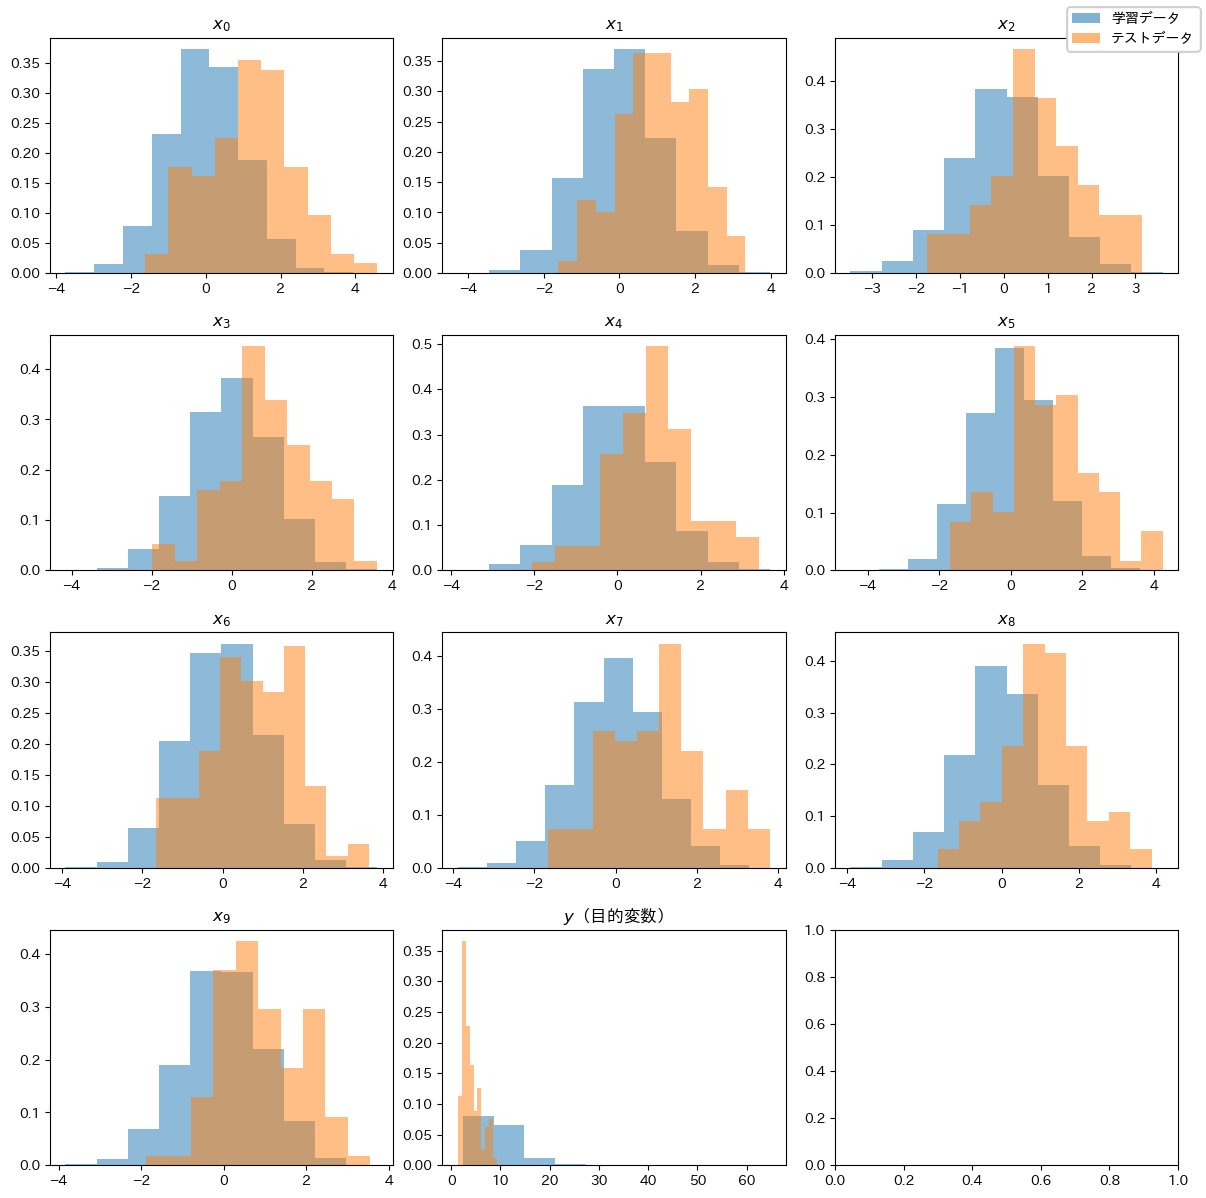

In [4]:
n_features = x.shape[1]
ncols = 3
nrows = math.ceil(n_features / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*3, ncols*4), tight_layout=True)

for i in range(0, n_features+1):
    ax = axes[i//ncols, i%ncols]
    if i < n_features:
        ax.hist(x[:, i], density=True, alpha=0.5)
        ax.hist(xdash[:, i], density=True, alpha=0.5)
        ax.set_title(f'$x_{i}$')
    else:
        ax.hist(y, density=True, alpha=0.5)
        ax.hist(ydash, density=True, alpha=0.5)
        ax.set_title(f'$y$（目的変数）')
    fig.legend(['学習データ', 'テストデータ'])
plt.show()

### 通常のリッジ回帰

In [5]:
ri = Ridge()
ri.fit(x, y)
ydash_hat = ri.predict(xdash)
yhat = ri.predict(x)

In [6]:
print('学習データ: ', np.sqrt(mean_squared_error(y, yhat)))
print('テストデータ: ', np.sqrt(mean_squared_error(ydash, ydash_hat)))

学習データ:  2.844616829201501
テストデータ:  4.411844685127307


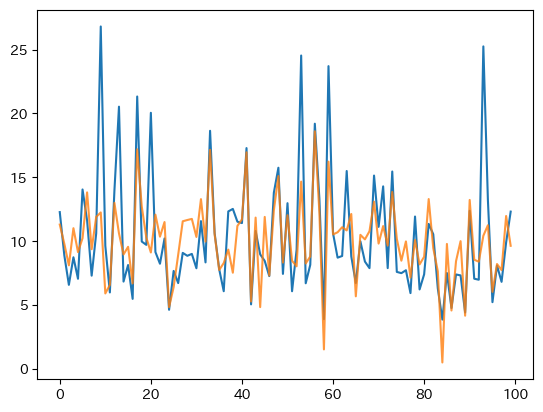

In [7]:
plt.plot(y[:100])
plt.plot(yhat[:100], alpha=0.8)

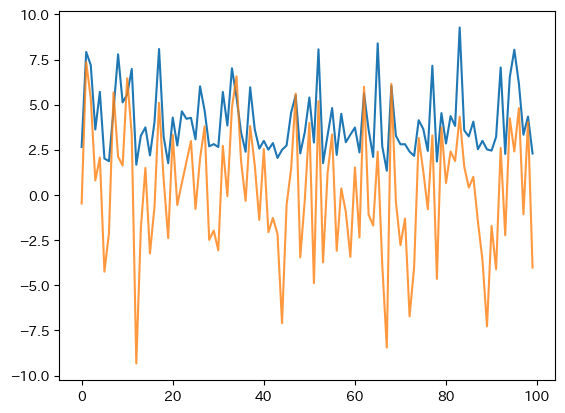

In [8]:
plt.plot(ydash)
plt.plot(ydash_hat, alpha=0.8)

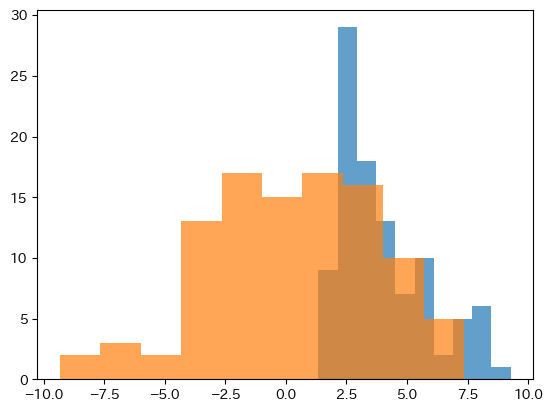

In [9]:
plt.hist(ydash, alpha=0.7)
plt.hist(ydash_hat, alpha=0.7)
plt.show()

### RuLSIFでsample_weightを計算

In [10]:
# ハイパラを探索
kf = KFold(n_splits=3, random_state=18, shuffle=True)

min_sigma, min_lda, min_beta, alpha_hat = rulsif.search_min_score(
    x, y, xdash, sigma_range=[0.1, 0.5, 1.0], lda_range=[0.001, 0.01, 0.1], 
    beta_range=[0.1, 0.5, 0.9], cv=kf, model=Ridge())

sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sigma = 0.5, lda = 0.001, beta = 0.1, validation score = 1.1325645620638312
sigma = 0.5, lda = 0.001, beta = 0.5, validation score = 1.3576193763154956
sigma = 0.5, lda = 0.001, beta = 0.9, validation score = 1.4462653576219948
sigma = 0.5, lda = 0.01, beta = 0.1, validation score = 1.460519575140447
sigma = 0.5, lda = 0.01, beta = 0.5, validation score = 1.5029834980166263
sigma = 0.5, lda = 0.01, beta = 0.9, validation score = 1.5304628442262784
sigma = 0.5, lda = 0.1, beta = 0.1,

In [11]:
# 探索したハイパラでw_alpha(x')を計算
w_alpha = rulsif.compute_w_alpha_x(x, xdash, alpha_hat, sigma=min_sigma)

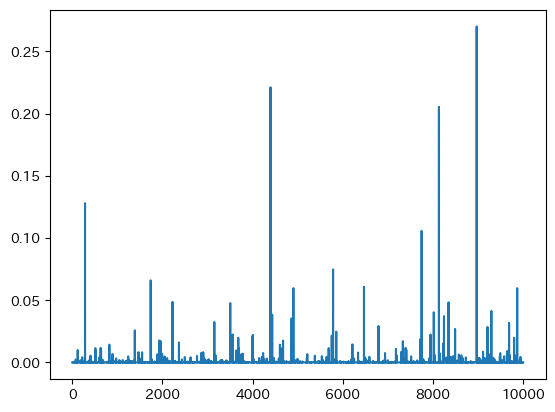

In [12]:
plt.plot(w_alpha)

In [13]:
ri = Ridge()
ri.fit(x, y, sample_weight=w_alpha) # sample_weightにw_alpha(x')を代入
ydash_hat = ri.predict(xdash)
yhat_train = ri.predict(x)

print('学習データ: ', np.sqrt(mean_squared_error(y, yhat_train)))
print('テストデータ: ', np.sqrt(mean_squared_error(ydash, ydash_hat)))

学習データ:  5.414122506972473
テストデータ:  1.470995591406775


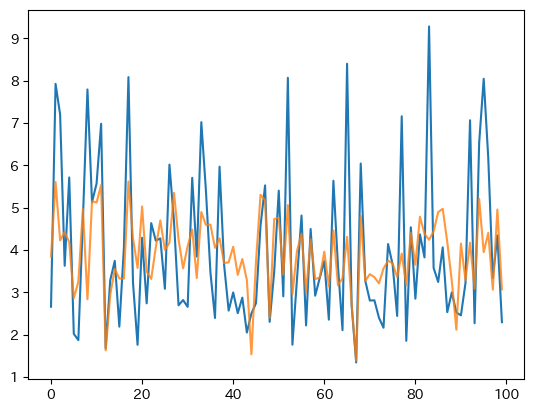

In [14]:
plt.plot(ydash)
plt.plot(ydash_hat, alpha=0.8)

(array([ 3.,  1.,  1.,  8., 23., 13., 20., 13., 12.,  6.]),
 array([1.38855963, 1.81171993, 2.23488023, 2.65804054, 3.08120084,
        3.50436114, 3.92752145, 4.35068175, 4.77384205, 5.19700235,
        5.62016266]),
 <BarContainer object of 10 artists>)

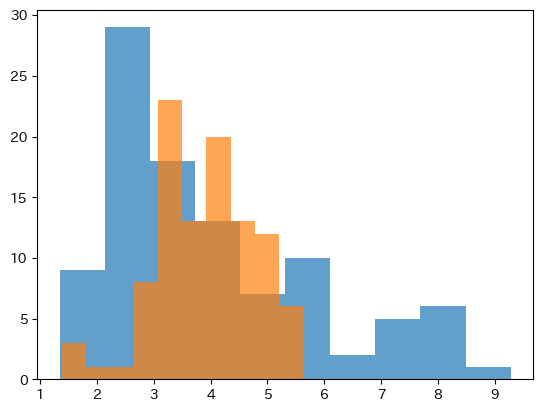

In [15]:
plt.hist(ydash, alpha=0.7)
plt.hist(ydash_hat, alpha=0.7)

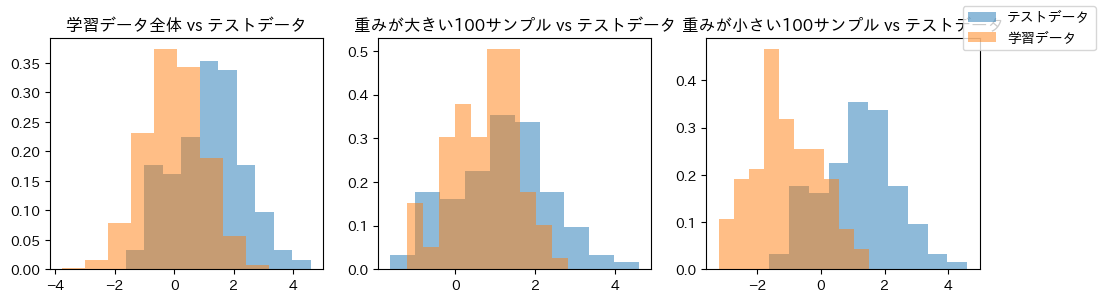

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))
above_index = w_alpha > np.sort(w_alpha)[-100]
below_index = w_alpha < np.sort(w_alpha)[100]
axes[0].hist(xdash[:, 0], density=True, alpha=0.5)
axes[0].hist(x[:, 0], density=True, alpha=0.5)
axes[0].set_title('学習データ全体 vs テストデータ')
axes[1].hist(xdash[:, 0], density=True, alpha=0.5)
axes[1].hist(x[above_index, 0], density=True, alpha=0.5)
axes[1].set_title('重みが大きい100サンプル vs テストデータ')
axes[2].hist(xdash[:, 0], density=True, alpha=0.5)
axes[2].hist(x[below_index, 0], density=True, alpha=0.5)
axes[2].set_title('重みが小さい100サンプル vs テストデータ')
fig.legend(['テストデータ','学習データ'])
plt.show()

# 電力データでチャレンジ
* https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

In [17]:
df = pd.read_csv('./data/energydata_complete.csv', index_col=0)

In [18]:
TARGET = 'Appliances'
EXPOLANATORY = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint']

In [19]:
train_date = '2016-03-31'

train_df = df.loc[:train_date, :]
test_df = df.loc[train_date:'2016-04-01', :]

In [20]:
import math

def check_histgram(df, dfdash, ncols=3):
    # plt.(h_pad=0.3)
    nrows = math.ceil(df.shape[1] / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3), tight_layout=True)

    for i, c in enumerate(df.columns):
        ax = axes[i//ncols, i%ncols]
        df[c].astype(np.float32).hist(density=True, alpha=0.5, ax=ax)
        dfdash[c].astype(np.float32).hist(density=True, alpha=0.5, ax=ax)
        ax.set_title(c)
        fig.legend(['学習データ', 'テストデータ'])
    plt.show()

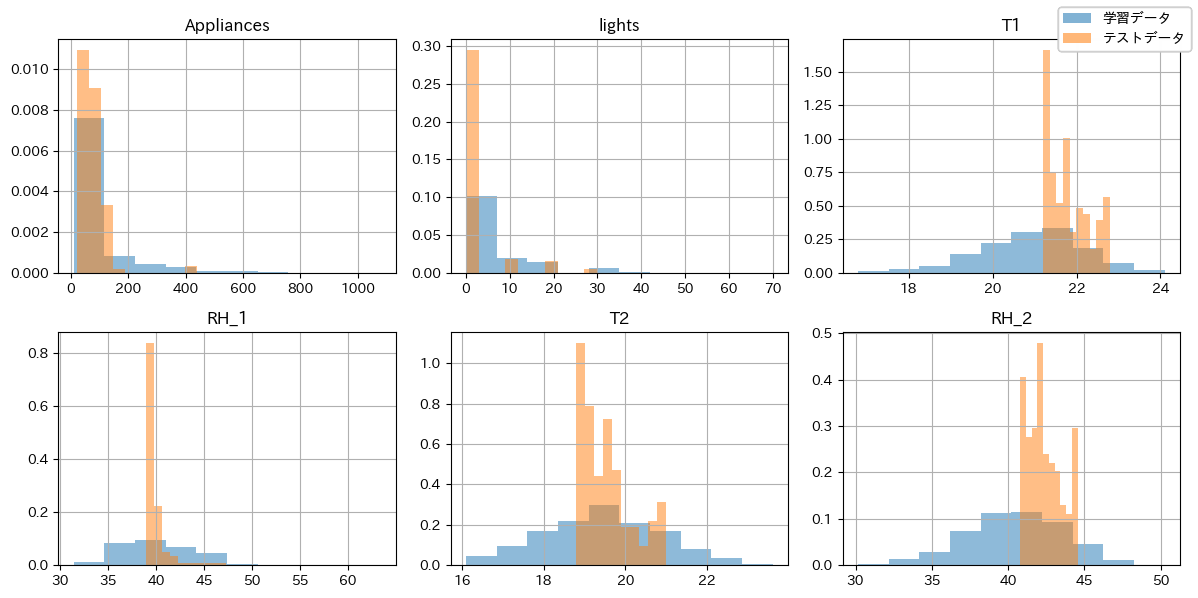

In [21]:
check_histgram(train_df.iloc[:, :6], test_df.iloc[:, :6])

### 前処理（正規化）

In [22]:
m = train_df.loc[:, EXPOLANATORY].mean()
s = train_df.loc[:, EXPOLANATORY].std() + 1e-5

In [23]:
train_df.loc[:, EXPOLANATORY] = (train_df.loc[:, EXPOLANATORY] - m)/s
test_df.loc[:, EXPOLANATORY] = (test_df.loc[:, EXPOLANATORY] - m)/s

In [24]:
xtr = train_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
ytr = train_df[TARGET].to_numpy()
xts = test_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
yts = test_df[TARGET].to_numpy()

### 通常のリッジ回帰

In [25]:
# normal
ri = Ridge()
ri.fit(xtr, ytr)
yhat = ri.predict(xts)

# RMSE
print(np.sqrt(mean_squared_error(yts, yhat)))

0.41534469382091666


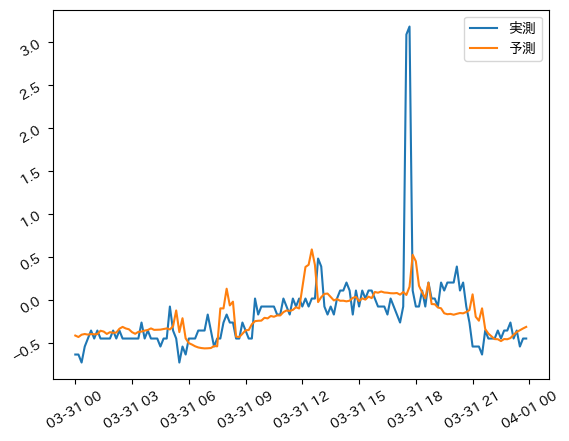

In [26]:
plt.plot(pd.to_datetime(test_df.index), yts)
plt.plot(pd.to_datetime(test_df.index), yhat)
plt.tick_params(rotation=30)
plt.legend(['実測', '予測'])
plt.show()

### RuLSIFでsample_weightを計算

In [27]:
cv = TimeSeriesSplit(n_splits=3)

min_sigma, min_lda, min_beta, alpha_hat = rulsif.search_min_score(
    xtr, ytr, xts, sigma_range=[0.1, 0.5, 1.0], lda_range=[0.001, 0.01, 0.1], 
    beta_range=[0.1, 0.5, 0.9], cv=cv, model=Ridge())

sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost 

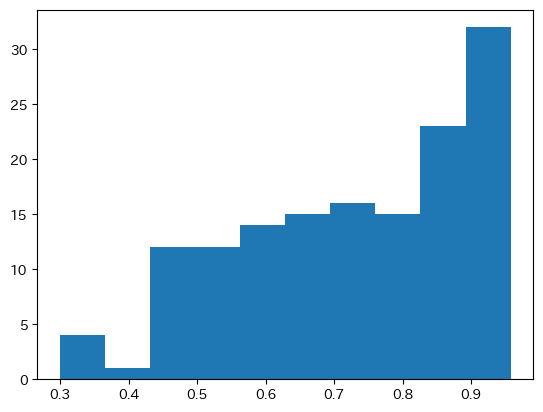

In [28]:
plt.hist(alpha_hat)
plt.show()

In [29]:
w_alpha = rulsif.compute_w_alpha_x(
    xtr, xts, alpha_hat, sigma=min_sigma)

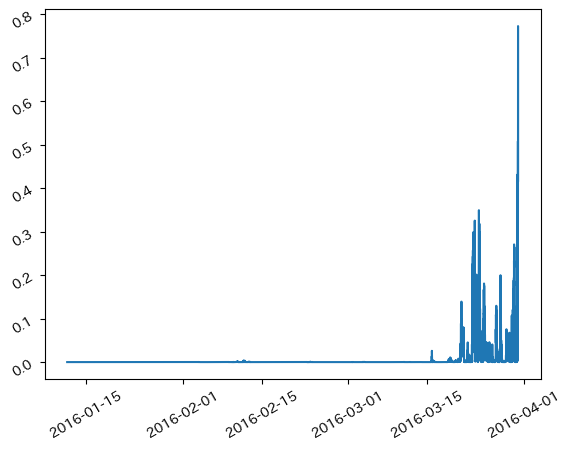

In [30]:
plt.plot(pd.to_datetime(train_df.index), w_alpha)
plt.tick_params(rotation=30)
plt.show()

In [31]:
# normal
ri = Ridge()
ri.fit(xtr, ytr, sample_weight=w_alpha)
yhat_rulsif = ri.predict(xts)

print(np.sqrt(mean_squared_error(yts, yhat_rulsif)))

0.39588573556513784


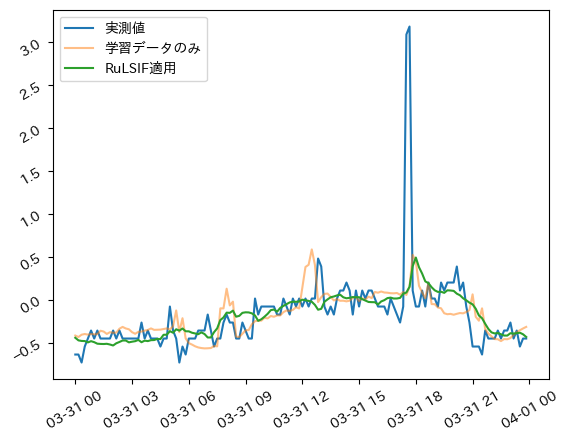

In [32]:
test_index = pd.to_datetime(test_df.index)
plt.plot(test_index, yts)
plt.plot(test_index, yhat, alpha=0.5)
plt.plot(test_index, yhat_rulsif)
plt.legend(['実測値', '学習データのみ', 'RuLSIF適用'])
plt.tick_params(rotation=30)
plt.show()

## 共変量シフトの確認

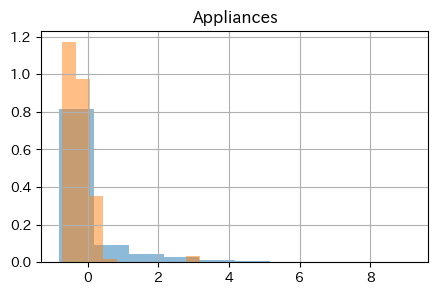

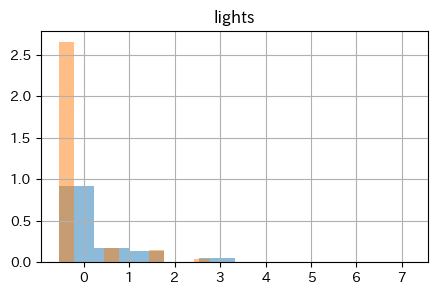

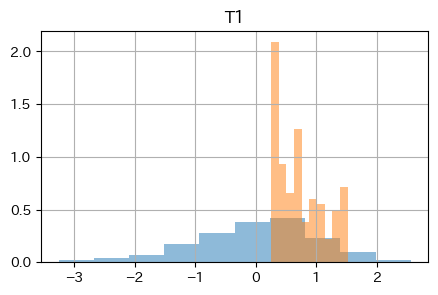

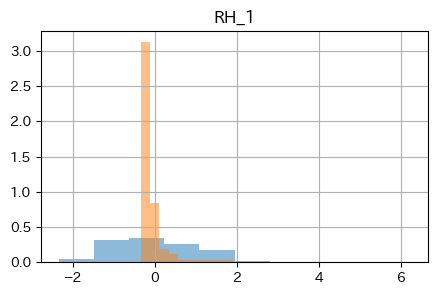

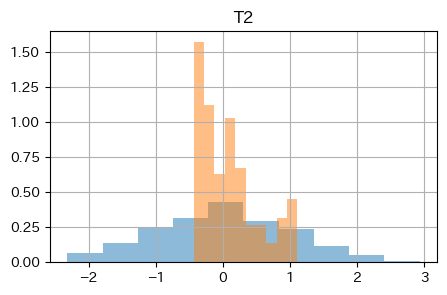

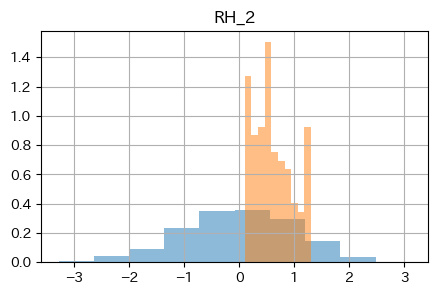

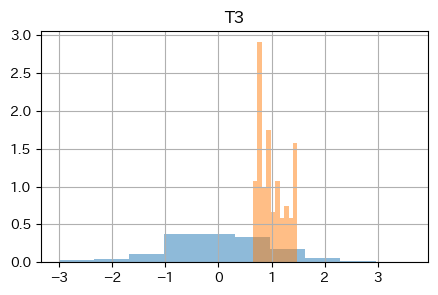

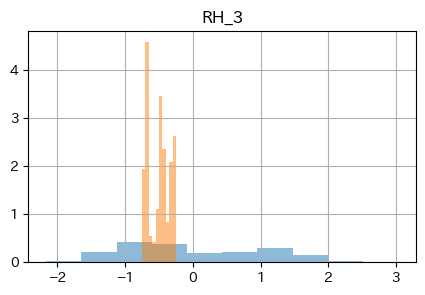

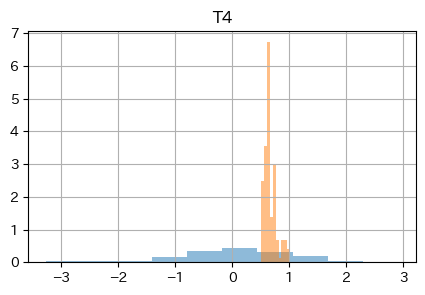

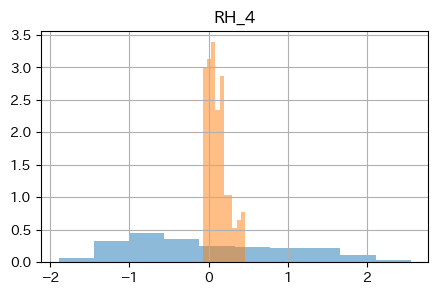

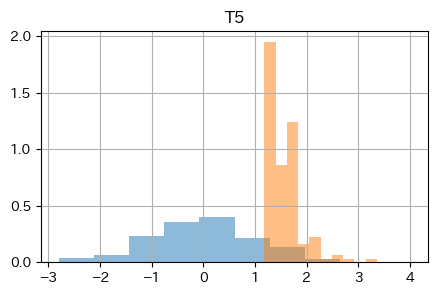

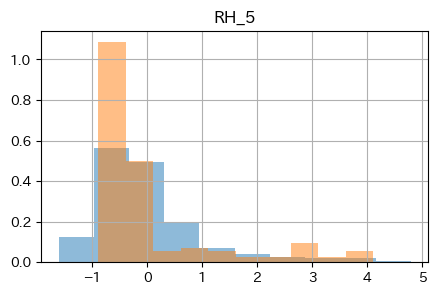

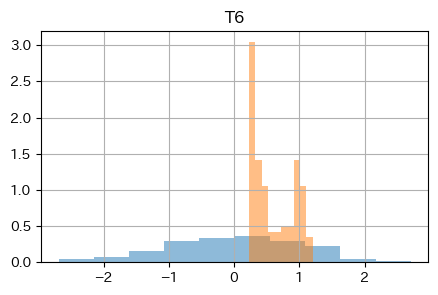

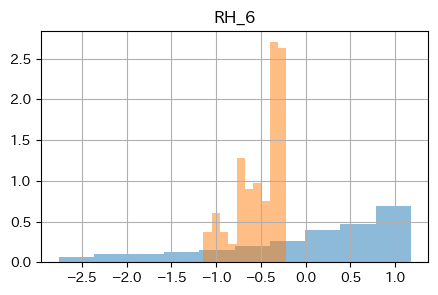

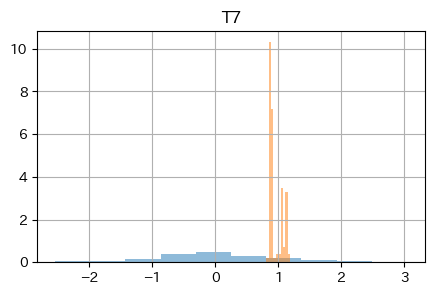

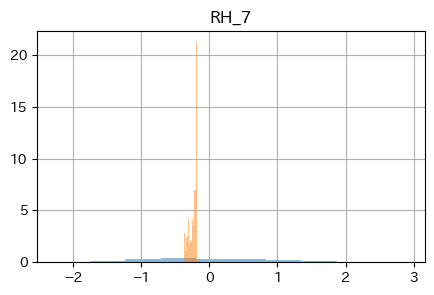

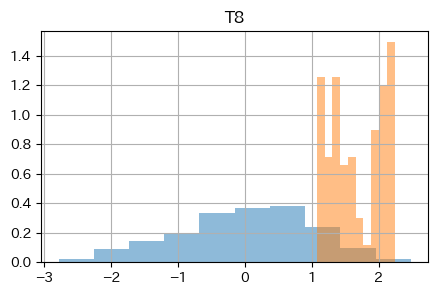

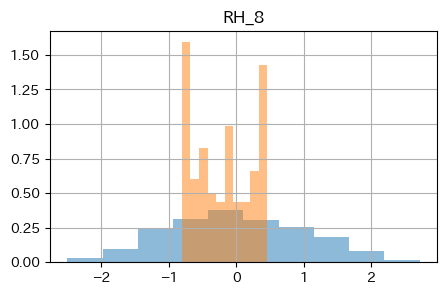

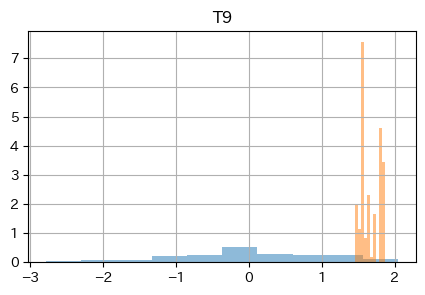

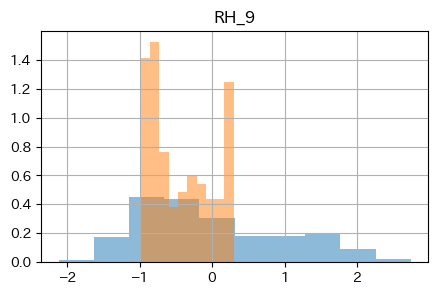

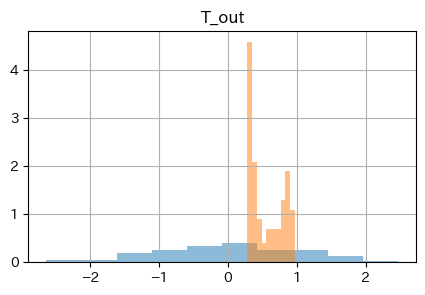

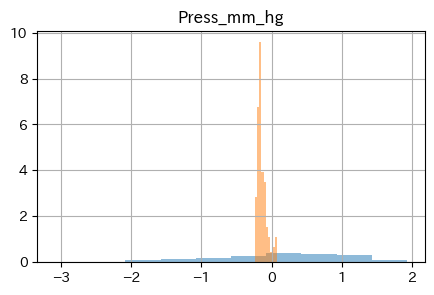

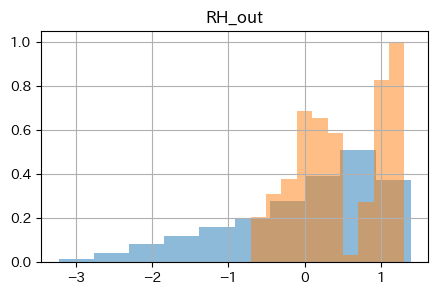

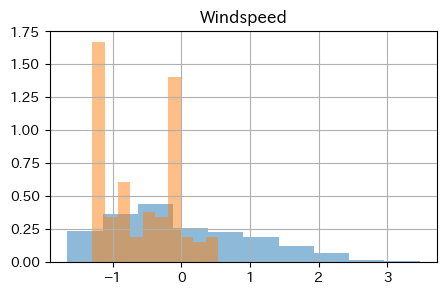

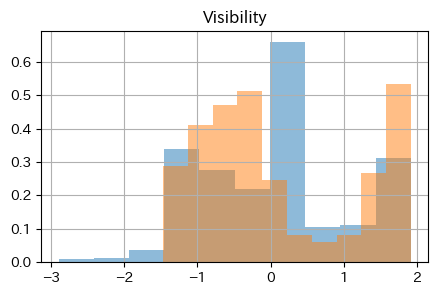

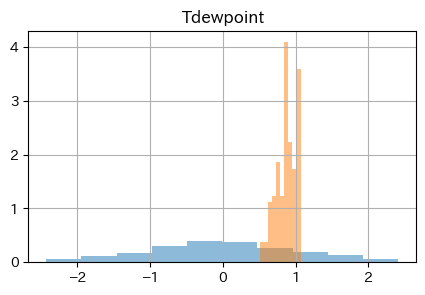

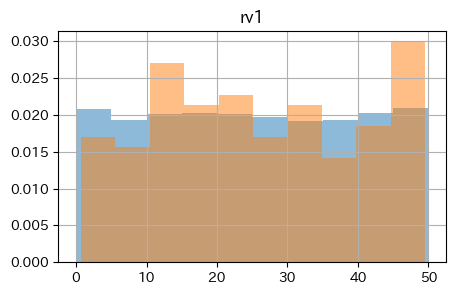

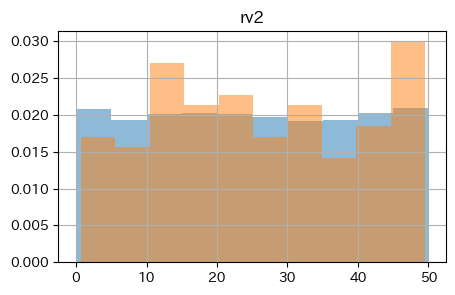

In [33]:
for c in train_df.columns:
    train_df[c].astype(np.float32).hist(density=True, alpha=0.5, figsize=(5,3))
    test_df[c].astype(np.float32).hist(density=True, alpha=0.5)
    plt.title(c)
    plt.show()

# オーストラリア電力需要でチャレンジ
* https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia

In [34]:
df = pd.read_csv('./data/オーストラリア_電力需要.csv', index_col=0, encoding='ShiftJIS')

In [35]:
df.columns

Index(['総電力需要(MWh)', '希望小売価格(AUD$/MWh)', '正の価格時の総電力需要(MWh)', '正の価格(AUD$/MWh)',
       '負の価格時の総電力需要(MWh)', '負の価格(AUD$/MWh)', '負の価格で取引された割合', '最低気温', '最高気温',
       '日光エネルギー(MJ/m^2)', '降水量', '登校日', '休日'],
      dtype='object')

In [36]:
TARGET = '総電力需要(MWh)'
EXPORANALTORY =  ['希望小売価格(AUD$/MWh)', '正の価格(AUD$/MWh)',
       '負の価格(AUD$/MWh)', '負の価格で取引された割合', '最低気温', '最高気温',
       '日光エネルギー(MJ/m^2)', '降水量', '登校日_Y', '休日_Y']

df = pd.get_dummies(df, drop_first=True)
df = df.bfill()

In [37]:
train_date = '2018-12-31'

train_df = df[[TARGET] + EXPORANALTORY].loc[:train_date, :]
test_df = df[[TARGET] + EXPORANALTORY].loc[train_date:'2019-03-01', :]

### 共変量シフトの確認

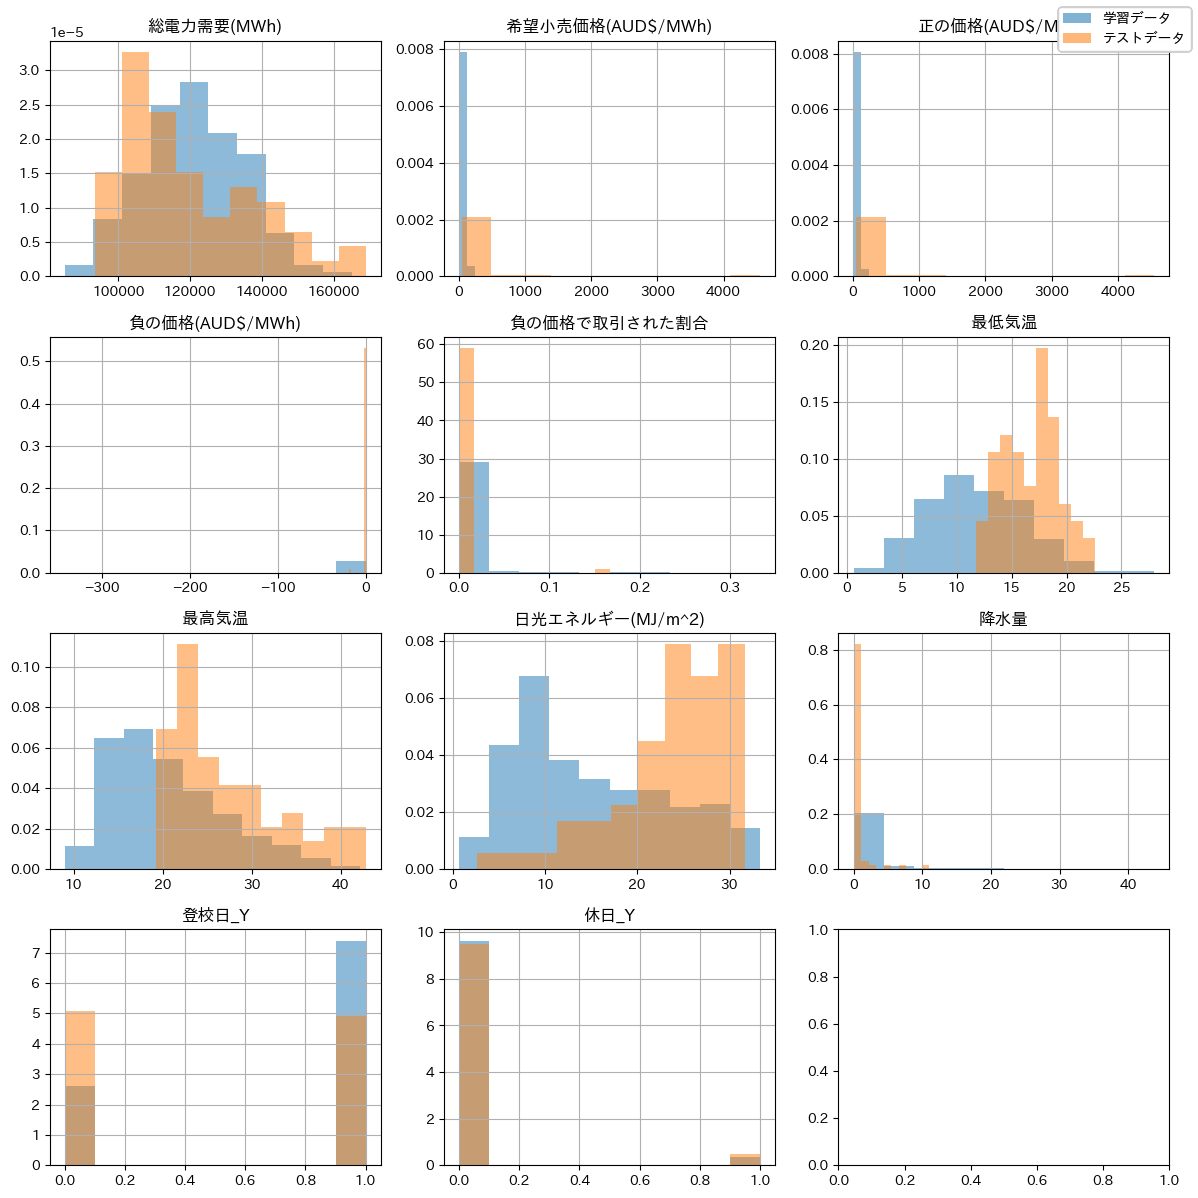

In [38]:
check_histgram(train_df, test_df)

### 前処理

In [39]:
m = train_df.loc[:, EXPORANALTORY[:-2]].mean()
s = train_df.loc[:, EXPORANALTORY[:-2]].std() + 1e-5

In [40]:
train_df.loc[:, EXPORANALTORY[:-2]] = (train_df.loc[:, EXPORANALTORY[:-2]] - m)/s
test_df.loc[:, EXPORANALTORY[:-2]] = (test_df.loc[:, EXPORANALTORY[:-2]] - m)/s

In [41]:
xtr = train_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
ytr = train_df[TARGET].to_numpy()
xts = test_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
yts = test_df[TARGET].to_numpy()

### 通常のリッジ回帰

In [42]:
# normal
ri = Ridge()
ri.fit(xtr, ytr)
yhat = ri.predict(xts)

print('---全体---')
print(np.sqrt(mean_squared_error(yts, yhat)))
print(mean_absolute_error(yts, yhat))

print('\n---外れ値削除後---')
index = yhat < 200000 
print(np.sqrt(mean_squared_error(yts[index], yhat[index])))
print(mean_absolute_error(yts[index], yhat[index]))

---全体---
27785.00463091179
13961.257300204921

---外れ値削除後---
12847.270537454722
10979.85900520834


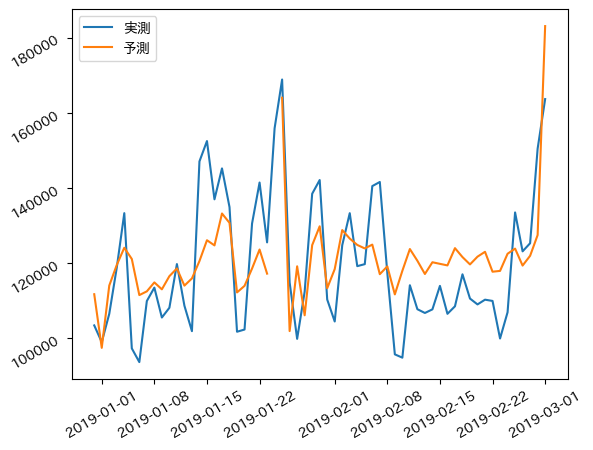

In [43]:
plt.plot(pd.to_datetime(test_df.index), yts)

yhat[~index] = np.nan
plt.plot(pd.to_datetime(test_df.index), yhat)
plt.tick_params(rotation=30)
plt.legend(['実測', '予測'])
plt.show()

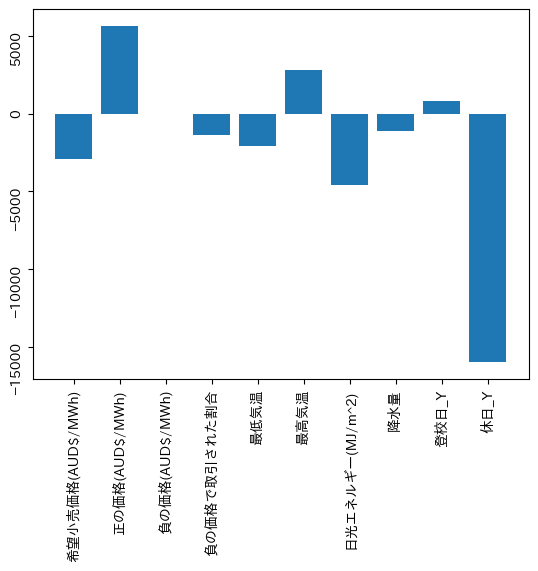

In [44]:
plt.bar(EXPORANALTORY, ri.coef_)
plt.tick_params(rotation=90)
plt.show()

### RuLSIFでsample_weightを計算

In [45]:
cv = TimeSeriesSplit(n_splits=3)

min_sigma, min_lda, min_beta, alpha_hat = rulsif.search_min_score(
    xtr, ytr, xts, sigma_range=[0.1, 0.5, 1.0], lda_range=[0.001, 0.01, 0.1], 
    beta_range=[0.1, 0.5, 0.9], cv=cv, model=Ridge())

sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sigma = 0.5, lda = 0.001, beta = 0.1, validation score = 142511719.95408493
sigma = 0.5, lda = 0.001, beta = 0.5, validation score = 145712450.43477452
sigma = 0.5, lda = 0.001, beta = 0.9, validation score = 143666454.74344757
sigma = 0.5, lda = 0.01, beta = 0.1, validation score = 143037355.30521116
sigma = 0.5, lda = 0.01, beta = 0.5, validation score = 142249902.40518007
sigma = 0.5, lda = 0.01, beta = 0.9, validation score = 141761296.61074397
sigma = 0.5, lda = 0.1, beta = 0.1

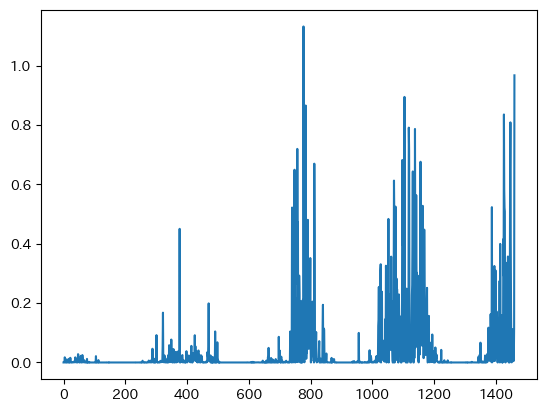

In [46]:
w_alpha = rulsif.compute_w_alpha_x(xtr, xts, alpha_hat, sigma=min_sigma)
plt.plot(w_alpha)

In [47]:
ri = Ridge()
ri.fit(xtr, ytr, sample_weight=w_alpha)
yhat_rulsif = ri.predict(xts)

print('---全体---')
print(np.sqrt(mean_squared_error(yts, yhat_rulsif)))
print(mean_absolute_error(yts, yhat_rulsif))

print('\n---外れ値削除後---')
index = yhat_rulsif < 200000
print(np.sqrt(mean_squared_error(yts[index], yhat_rulsif[index])))
print(mean_absolute_error(yts[index], yhat_rulsif[index]))

---全体---
51256.34301507383
15992.028647540988

---外れ値削除後---
9746.293898880174
8013.9419612069


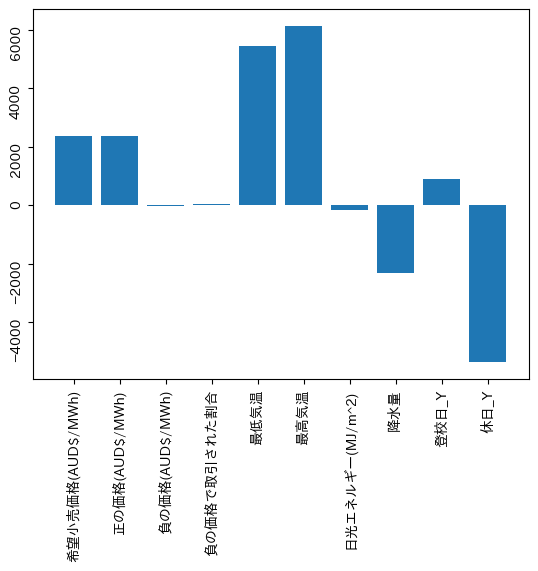

In [48]:
plt.bar(EXPORANALTORY, ri.coef_)
plt.tick_params(rotation=90)
plt.show()

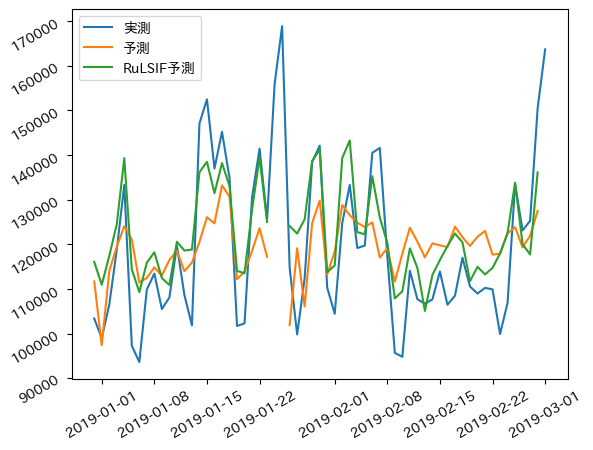

In [49]:
plt.plot(pd.to_datetime(test_df.index), yts)
yhat[~index] = np.nan
yhat_rulsif[~index] = np.nan
plt.plot(pd.to_datetime(test_df.index), yhat)
plt.plot(pd.to_datetime(test_df.index), yhat_rulsif)
plt.tick_params(rotation=30)
plt.legend(['実測', '予測', 'RuLSIF予測'])
plt.show()

## VAMSimデータを利用
* https://gochikika.ntt.com/Introduction/datasets.html

In [50]:
df = pd.read_csv('./data/2020413.csv', index_col=0, parse_dates=True, encoding='shift-jis')

In [51]:
reacter = [c for c in df.columns if c.startswith('反応器')]

In [52]:
df = df[reacter]

In [53]:
df.head()

,反応器出口温度_PV,反応器出口温度_SV,反応器外殻温度_MV,反応器流入組成（O2）_PV,反応器流入組成（O2）_SV,反応器流入組成（CO2）_PV,反応器流入組成（C2H4）_PV,反応器流入組成（C2H6）_PV,反応器流入組成（VAc）_PV,反応器流入組成（H2O）_PV,反応器流入組成（HAc）_PV
2020-04-13 00:00:00,160.387755,159.17,135.018392,0.074659,0.075,0.006273,0.585715,0.214016,0.001370,0.008524,0.109444
2020-04-13 00:00:01,160.368978,159.17,135.018392,0.075105,0.075,0.006286,0.585342,0.213945,0.001368,0.008512,0.109441
2020-04-13 00:00:02,160.440578,159.17,134.778196,0.074506,0.075,0.006281,0.584384,0.215043,0.001373,0.008541,0.109871
2020-04-13 00:00:03,160.382615,159.17,134.603321,0.075398,0.075,0.006289,0.584467,0.214126,0.001372,0.008573,0.109775
2020-04-13 00:00:04,160.378797,159.17,134.497927,0.075198,0.075,0.006313,0.584698,0.214002,0.001374,0.008547,0.109868


In [54]:
df = df.asfreq('60s')

<Axes: >

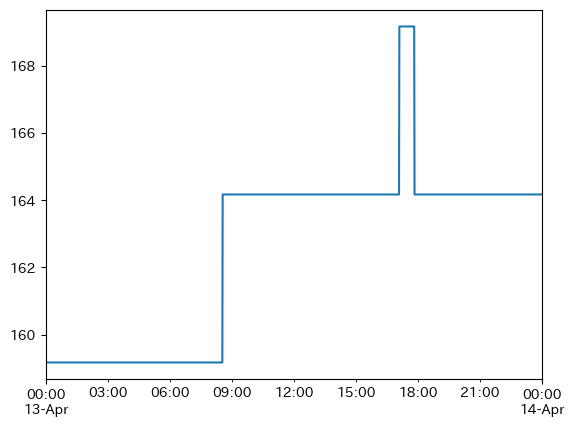

In [55]:
df['反応器出口温度_SV'].plot()

In [56]:
TARGET = '反応器出口温度_PV'

train_date = '2020-04-13 19:00'

train_df = df.loc[:train_date, :]
test_df = df.loc[train_date:, :]

In [57]:
m = train_df.drop(TARGET, axis=1).mean()
s = train_df.drop(TARGET, axis=1).std() + 1e-5

EX_COLUMNS = train_df.drop(TARGET, axis=1).columns

In [58]:
train_df.loc[:, EX_COLUMNS] = (train_df[EX_COLUMNS] - m)/s
test_df.loc[:, EX_COLUMNS] = (test_df[EX_COLUMNS]- m)/s

In [59]:
xtr = train_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
ytr = train_df[TARGET].to_numpy()
xts = test_df.drop(TARGET, axis=1).to_numpy().astype(np.float32)
yts = test_df[TARGET].to_numpy()

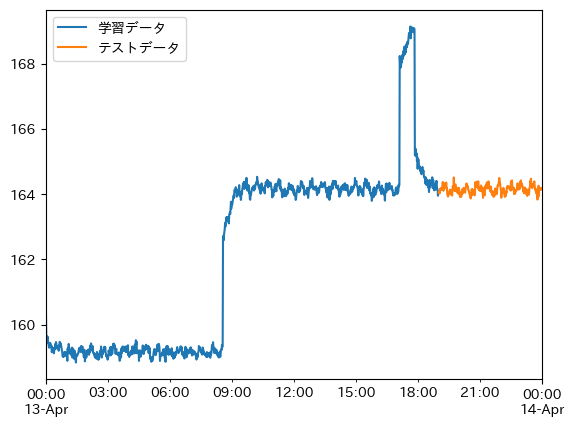

In [60]:
train_df[TARGET].plot()
test_df[TARGET].plot()
plt.legend(['学習データ','テストデータ'])
plt.show()

### 通常のリッジ回帰

In [61]:
# normal
ri = Ridge()
ri.fit(xtr, ytr)
yhat = ri.predict(xts)

print(np.sqrt(mean_squared_error(yts, yhat)))

0.2205845817401135


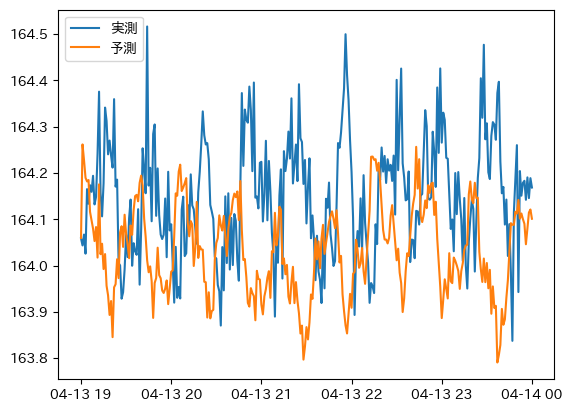

In [62]:
plt.plot(test_df.index, yts)
plt.plot(test_df.index, yhat)
plt.legend(['実測', '予測'])
plt.show()

### RuLSIFでsample_weightを計算

In [63]:
cv = TimeSeriesSplit(n_splits=3)

min_sigma, min_lda, min_beta, alpha_hat = rulsif.search_min_score(
    xtr, ytr, xts, sigma_range=[0.1, 0.5, 1.0], lda_range=[0.001, 0.01, 0.1], 
    beta_range=[0.1, 0.5, 0.9], cv=cv, model=Ridge())

sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sum of train w alpha is almost zero. skip this iteration
sigma = 0.5, lda = 0.001, beta = 0.1, validation score = 7.0972912388939235
sigma = 0.5, lda = 0.001, beta = 0.5, validation score = 6.998293455317357
sigma = 0.5, lda = 0.001, beta = 0.9, validation score = 6.953551241223099
sigma = 0.5, lda = 0.01, beta = 0.1, validation score = 7.770031508258463
sigma = 0.5, lda = 0.01, beta = 0.5, validation score = 7.443246327686045
sigma = 0.5, lda = 0.01, beta = 0.9, validation score = 7.341032038160975
sigma = 0.5, lda = 0.1, beta = 0.1, val

In [64]:
w_alpha = rulsif.compute_w_alpha_x(xtr, xts, alpha_hat, sigma=min_sigma)

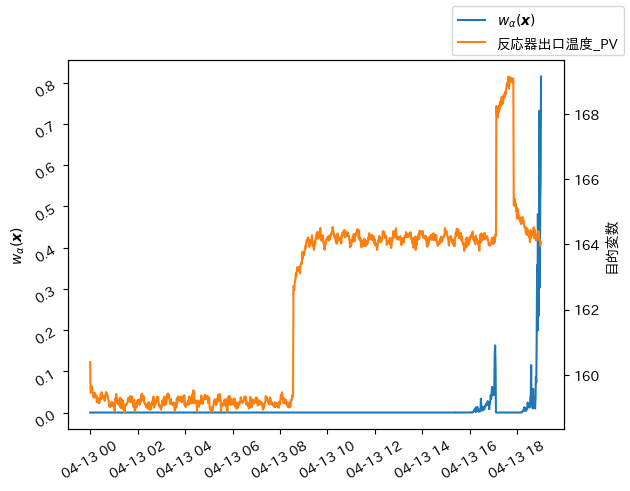

In [65]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(train_df.index, w_alpha, color='C0')
ax1.plot(train_df.index, ytr, color='C1')
ax.tick_params(rotation=30)
ax.set_ylabel(r'$w_\alpha(\boldsymbol{x})$')
ax1.set_ylabel('目的変数')
fig.legend([r'$w_\alpha(\boldsymbol{x})$', f'{TARGET}'])
plt.show()

In [66]:
ri = Ridge()
ri.fit(xtr, ytr, sample_weight=w_alpha)
yhat_rulsif = ri.predict(xts)

print('---全体---')
print(np.sqrt(mean_squared_error(yts, yhat_rulsif)))
print(mean_absolute_error(yts, yhat_rulsif))

---全体---
0.1537005655807329
0.12332763946438649


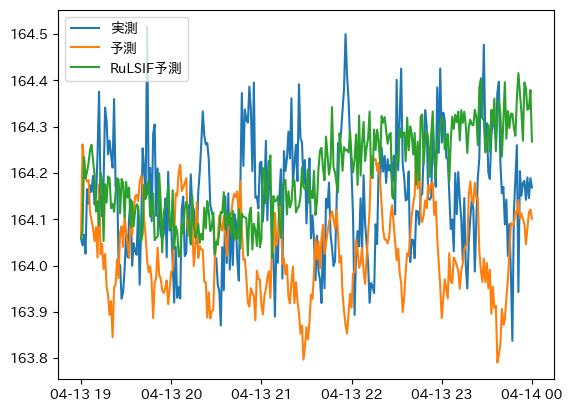

In [67]:
plt.plot(test_df.index, yts)
plt.plot(test_df.index, yhat)
plt.plot(test_df.index, yhat_rulsif)
plt.legend(['実測', '予測', 'RuLSIF予測'])
plt.show()